# Face Detection and Recognition

# Import Library

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load Image and Labels

In [35]:
# Load gambar menggunakan OpenCV dan mengubah keformat grayscale
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print('Error: Could not load image.')
        return None, None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

In [36]:
sample_image, sample_image_gray = load_image('data/images/George_W_Bush/1.jpg')

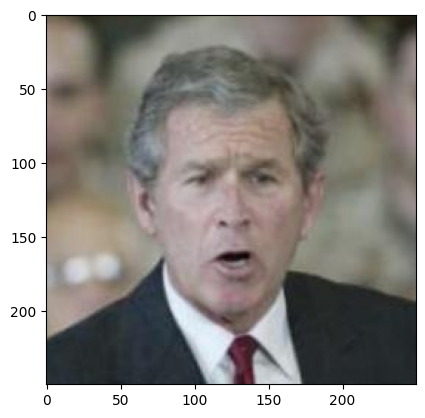

In [37]:
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)

In [38]:
# Load semua gambar dan mengekstrak label sesuai dengan nama direktori
dataset_dir = 'data/images'
images = []
labels = []
for root, dirs, files in os.walk(dataset_dir):
  if len(files) == 0:
    continue
  for f in files:
    _,image_gray = load_image(os.path.join(root, f))
    if image_gray is None:
      continue
    images.append(image_gray)
    labels.append(root.split('/')[-1])

# Face Detection

In [39]:
# Load Haar Cascade classifier untuk face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')

In [45]:

def detect_faces(image_gray, scale_factor=1.1, min_neighbors=5,
min_size=(30, 30)):
  """
    Deteksi wajah pada gambar grayscale.

    Parameters:
    - image_gray (ndarray): Gambar grayscale.
    - scale_factor (float): Pengaturan skala gambar. Default 1.1.
    - min_neighbors (int): Minimum neighbor untuk validasi wajah. Default 5.
    - min_size (tuple): Ukuran minimum wajah. Default (30, 30).

    Returns:
    - faces (ndarray): Koordinat (x, y, width, height) wajah terdeteksi.
  """
  faces = face_cascade.detectMultiScale(
    image_gray,
    scaleFactor=scale_factor,
    minNeighbors=min_neighbors,
    minSize=min_size
  )
  return faces

In [46]:
sample_face = detect_faces(sample_image_gray, min_size=(50,50))

In [47]:
# Cropping Faces
# Fungsi ini mendeteksi wajah dari gambar asli menggunakan bounding box coordinates
def crop_faces(image_gray, faces, return_all=False):
  cropped_faces = []
  selected_faces = []
  if len(faces) > 0:
    if return_all:
      for x, y, w, h in faces:
        selected_faces.append((x, y, w, h))
        cropped_faces.append(image_gray[y:y+h, x:x+w])
    else:
      x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
      selected_faces.append((x, y, w, h))
      cropped_faces.append(image_gray[y:y+h, x:x+w])
  return cropped_faces, selected_faces

In [48]:
crooped_faces, _= crop_faces(sample_image_gray, sample_face)

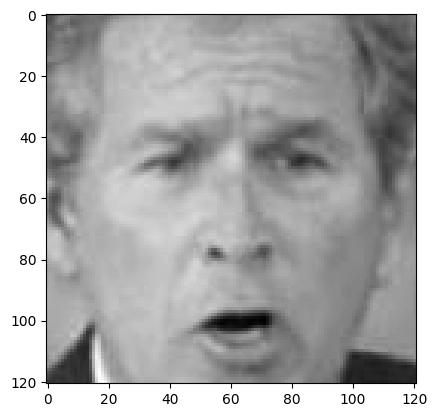

In [49]:
plt.imshow(crooped_faces[0], cmap='gray')

# Face Recognition â€” Eigenface

In [50]:
# Resize semua wajah yang terdeteksi
face_size = (128, 128)
def resize_and_flatten(face):
  face_resized = cv2.resize(face, face_size)
  face_flattened = face_resized.flatten()
  return face_flattened

In [51]:
# Prepare Training and Testing Data
X = []
y = []
for image, label in zip(images, labels):
  faces = detect_faces(image)
  cropped_faces, _ = crop_faces(image, faces)
  if len(cropped_faces) > 0:
    face_flattened = resize_and_flatten(cropped_faces[0])
    X.append(face_flattened)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=177, stratify=y)

In [53]:
# Mean Centering
from sklearn.base import BaseEstimator, TransformerMixin
class MeanCentering(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    self.mean_face = np.mean(X, axis=0)
    return self
  def transform(self, X):
    return X - self.mean_face

In [54]:
# Extract Eigenfaces and Build Classifier

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
pipe = Pipeline([
  ('centering', MeanCentering()),
  ('pca', PCA(svd_solver='randomized', whiten=True,random_state=177)),
  ('svc', SVC(kernel='linear', random_state=177))
])

In [55]:
# Train and Evaluate the Model
from sklearn.metrics import classification_report
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                                        precision    recall  f1-score   support

                   images\Abdullah_Gul       1.00      1.00      1.00         4
                   images\Alvaro_Uribe       0.67      0.80      0.73         5
images\Alvaro_Uribe\.ipynb_checkpoints       0.00      0.00      0.00         1
                  images\George_W_Bush       1.00      0.33      0.50         3
                     images\Laura_Bush       0.75      1.00      0.86         3
                images\Serena_Williams       1.00      1.00      1.00         3
                        images\Tegar_2       0.67      1.00      0.80         2
                 images\Vladimir_Putin       0.50      0.33      0.40         3

                              accuracy                           0.75        24
                             macro avg       0.70      0.68      0.66        24
                          weighted avg       0.77      0.75      0.73        24



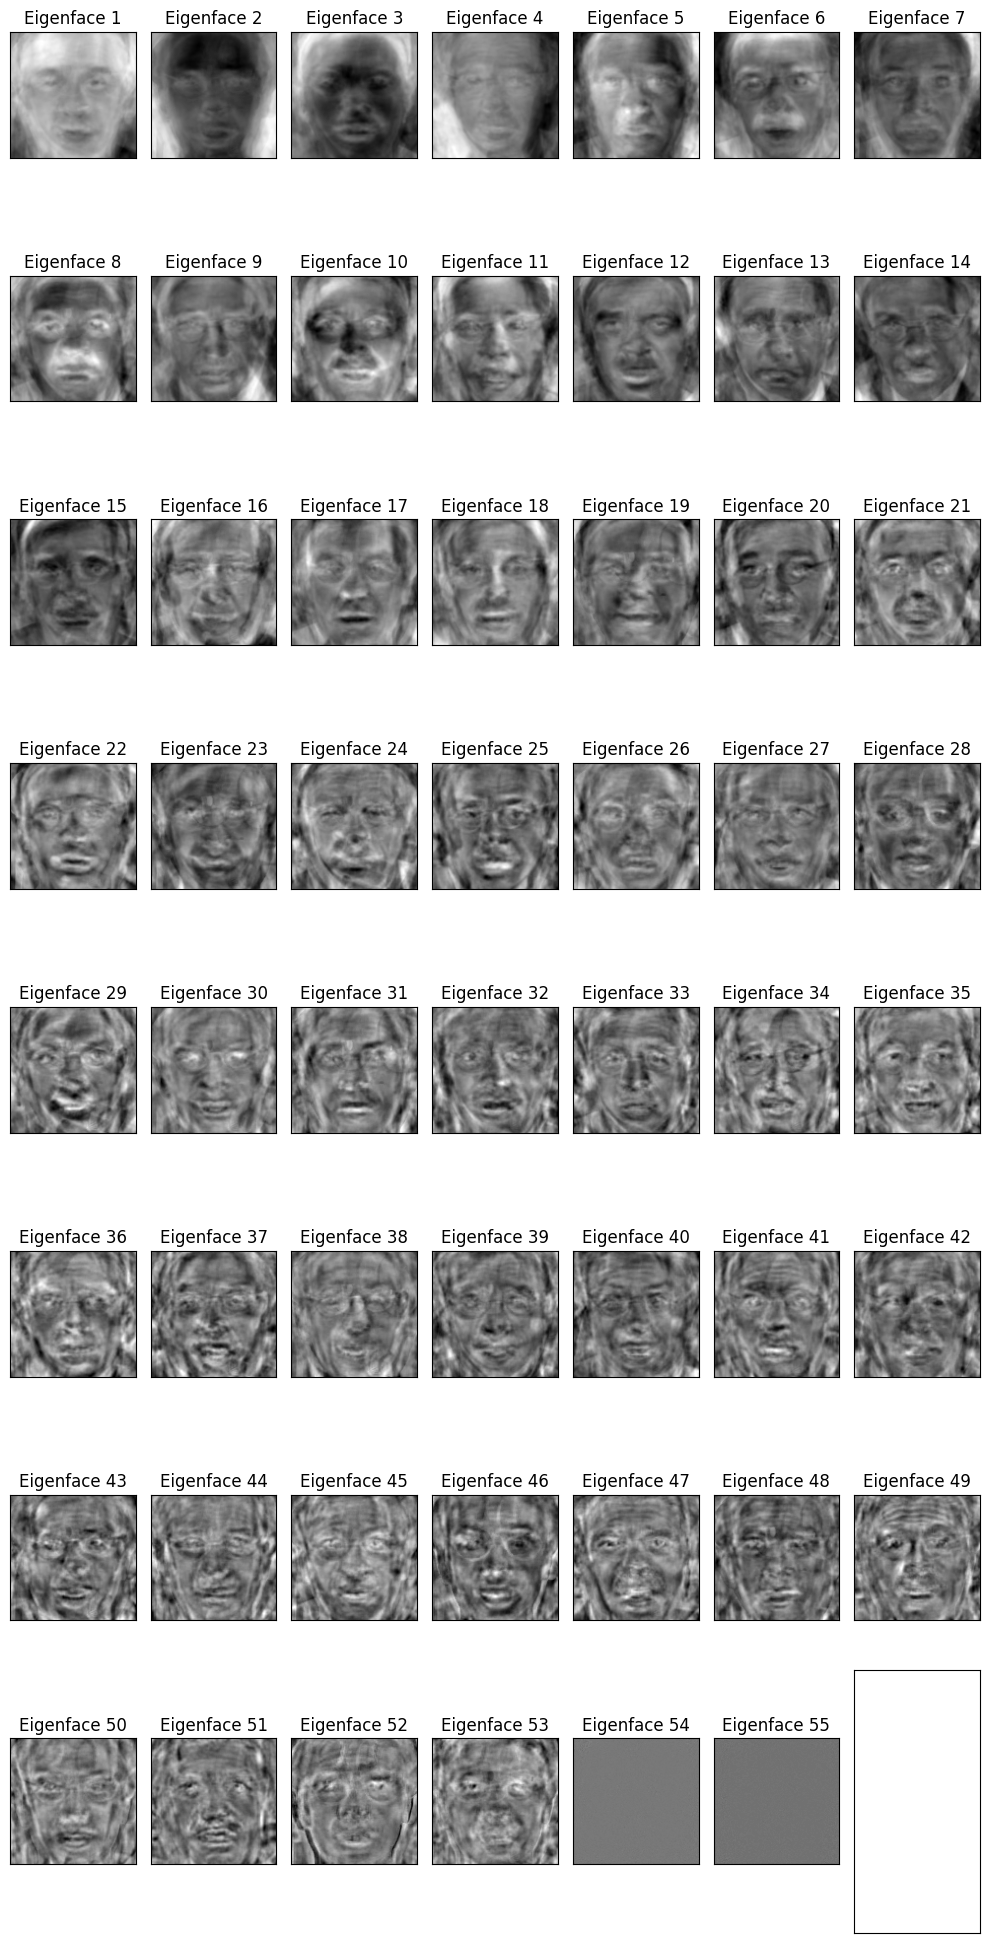

In [56]:
# Visualizing Eigenfaces

n_components = len(pipe[1].components_)
ncol = 7
nrow = (n_components + ncol - 1) // ncol
fig, axes = plt.subplots(nrow, ncol, figsize=(10, 2.5*nrow),
subplot_kw={'xticks':[], 'yticks':[]})
eigenfaces = pipe[1].components_.reshape((n_components,
X_train.shape[1]))
for i, ax in enumerate(axes.flat):
    if i >= n_components:
        break
    ax.imshow(eigenfaces[i].reshape(face_size), cmap='gray')
    ax.set_title(f'Eigenface {i+1}')
plt.tight_layout()
plt.show()

In [57]:
# Save the Model Pipeline
import pickle
with open('eigenface_pipeline.pkl', 'wb') as f:
    pickle.dump(pipe, f)

In [58]:
def get_eigenface_score(X):
  X_pca = pipe[:2].transform(X)
  eigenface_scores = np.max(pipe[2].decision_function(X_pca), axis=1)
  return eigenface_scores

In [59]:
def eigenface_prediction(image_gray):
  faces = detect_faces(image_gray)
  cropped_faces, selected_faces = crop_faces(image_gray, faces)
  if len(cropped_faces) == 0:
    return 'No face detected.'
  X_face = []
  for face in cropped_faces:
    face_flattened = resize_and_flatten(face)
    X_face.append(face_flattened)
  X_face = np.array(X_face)
  labels = pipe.predict(X_face)
  scores = get_eigenface_score(X_face)
  return scores, labels, selected_faces

# Visualize 

In [60]:
sample_scores, sample_label, sample_faces = eigenface_prediction(sample_image_gray)

In [61]:
def draw_text(image, label, score,
    font=cv2.FONT_HERSHEY_SIMPLEX,
    pos=(0, 0),
    font_scale=0.6,
    font_thickness=2,
    text_color=(0, 0, 0),
    text_color_bg=(0, 255, 0)
    ):

  x, y = pos
  score_text = f'Score: {score:.2f}'
  (w1, h1), _ = cv2.getTextSize(score_text, font, font_scale,font_thickness)
  (w2, h2), _ = cv2.getTextSize(label, font, font_scale,font_thickness)
  cv2.rectangle(image, (x, y-h1-h2-25), (x + max(w1, w2)+20, y),text_color_bg, -1)
  cv2.putText(image, label, (x+10, y-10), font, font_scale,text_color, font_thickness)
  cv2.putText(image, score_text, (x+10, y-h2-15), font, font_scale,text_color, font_thickness)

In [62]:
sample_scores, sample_label, sample_faces = eigenface_prediction(sample_image_gray)

In [63]:
def draw_result(image, scores, labels, coords):
  result_image = image.copy()
  for (x, y, w, h), label, score in zip(coords, labels, scores):
    cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0),2)
    draw_text(result_image, label, score, pos=(x, y))
  return result_image

In [64]:
result_image = draw_result(sample_image, sample_scores, sample_label, sample_faces)

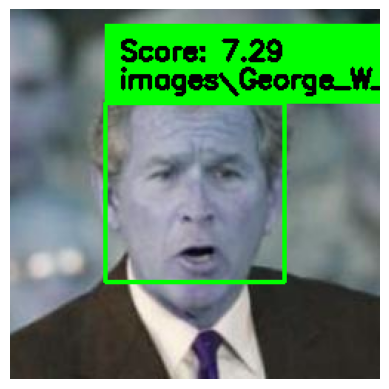

In [65]:
plt.imshow(result_image)
plt.axis('off')  # menghilangkan axis
plt.show()

# Real-Time Face Recognition Testing

In [66]:
import pickle
import cv2
import numpy as np

# 1. Load pipeline 
with open('eigenface_pipeline.pkl', 'rb') as f:
    pipe = pickle.load(f)

# 2. Inisialisasi webcam
cap = cv2.VideoCapture(0)  # 0 biasanya untuk webcam laptop

# 3. Loop untuk ambil frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 4. Preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # resize ke ukuran input saat training
    resized = cv2.resize(gray, (128, 128))  

    # 5. Reshape gambar ke 1 baris (flatten) 
    X_input = resized.flatten().reshape(1, -1)

    # 6. Prediksi
    prediction = pipe.predict(X_input)

    # 7. Tampilkan hasil prediksi
    label = prediction[0]
    cv2.putText(frame, str(label), (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # 8. Tampilkan frame
    cv2.imshow('Webcam Detection', frame)

    # 9. Tombol keluar
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 10. Release webcam
cap.release()
cv2.destroyAllWindows()
